<img src="https://ga-dash.s3.amazonaws.com/production/assets/logo-9f88ae6c9c3871690e33280fcf557f33.png" style="float: left; margin: 15px;">

## Image Compression Using PCA and SVD

_Author: Kiefer Katovich (SF) _

---

In this lab, we will write PCA and SVD from scratch and use them to compress and reconstruct images.

### Learning Objectives
- Understand grayscale image processing using NumPy.
- Understand the mathematics of PCA and SVD.
- Manually implement PCA and SVD.
- Build an image compression algorithm.

Below is an overview of the math behind principal component analysis (PCA) and a method to calculate it which is very common in many algorithms, the singular value decomposition (SVD).

### Lesson Guide
- [1. Load Dataset](#1.-Load-Dataset)
- [2. Understand the Dataset](#2.-Understand-the-Dataset)
- [3. Covariance of a Matrix](#3.-Covariance-of-a-Matrix)
- [4. An Ideal Data Representation](#4.-An-Ideal-Data-Representation) (the math of PCA)
- [5. Manually Coding PCA](#5.-Manually-Coding-PCA)
- [6. Singular Value Decomposition (SVD) to do PCA](#svd)
- [7. Manually Coding SVD](#7.-Manually-Coding-SVD)

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

sns.set_style("whitegrid")

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

## Faces Dataset
---

Let's load in the faces dataset from sklearn and pull out one of the faces.

### 1. Load Dataset

In [2]:
from sklearn.datasets import fetch_olivetti_faces

In [1]:
# Make sure you always understand *why* the shape is what it is
#   - There are 400 images of faces. (i.e. rows of data)
#   - Each image is 64x64 pixels, for a total of 4096 pixels. (i.e. features)



### 2. Understand the Dataset

In [9]:
# Keep in mind:
#   (4096,) -- A 1-element tuple.
#   (4096)  -- An integer.

face10 = faces[10]
print(face10.shape)

# This is a grayscale image, so each pixel is from 0 (black) to 1 (white)
face10

(4096,)


array([ 0.54132229,  0.58677685,  0.6404959 , ...,  0.09504132,
        0.11157025,  0.11157025], dtype=float32)

Set up a couple of functions, one to process an image (reshape it to a 2D matrix) and the other to actually plot the image matrix.

In [10]:
def plot_image_matrix(face_image):
    """ 
    Plots a grayscale 2-D ndarray `face_image`. 
        Pixel values can have any scale.
    """
    fig, ax = plt.subplots(figsize=(5,5))
    
    # max value (in magnitude)
    max_pixel_value = max(face_image.max(), -face_image.min())
    
    ax.imshow(face_image, cmap=plt.cm.gray,
              interpolation='nearest', 
              vmin=-max_pixel_value,
              vmax=max_pixel_value)
    
    ax.set_xticks(())
    ax.set_yticks(())

In [11]:
def process_image(image):
    """ 
    Standardize a 1-D 4096-element ndarray `image` to end up with:
      - A new 2-D 64x64-element ndarray, with
      - Pixel values between (-0.5, 0.5).
    """
    
    # Min-Max scaling to end up with values between (-0.5, 0.5)
    image = image - image.min()
    image = (image / image.max()) - 0.5
    
    # In this case, converts the 4096-element `image` to 64x64
    image = image.reshape((64, 64))       # The first parameter is a tuple
    return image

In [3]:
face10 = process_image(face10)

---

Always make sure you understand how the image is stored. Given the image below and the image matrix above:
- The top rows are light colored.
          So, the first few rows of numbers are > 0.0
- The final rows start dark and end dark. 
          So, the last few rows of numbers start and end < 0.0
- If you print out the full final row, what would you expect the middle numbers to look like?

In [4]:
# process and plot face10


Let's pull out a matrix of pixels -- just the eye of face #40.

In [5]:
# process and plot image 50


In [15]:
# This gets a 2D matrix - columns 5 up to 30 and pixel rows 10 up to 15.
#    Knowing this, what would you predict eye.shape to be? Verify your answer.

eye = process_image(faces[50])[5:30, 10:15]

---

### 3. Correlation and Covariance of a Matrix

In this section, we'll be treating each row of the eye image as an example. Each column will be a feature. So, the correlation between the columns will be how often all five columns change their pixel values together. In the eye image, notice the five columns are approximately the same across each row; so, we would expect them to have high correlation.

#### 3.A. Correlation Matrix

You should be able to intutively describe for the below correlation matrix:
- Why is a correlation matrix diagonal? What do the 1s mean?
- Why is this particular correlation matrix 5x5? What does each row/col correspond to in this case?
- What does it mean that all correlations are highly positive, in terms of the pixels?
- For PCA, would it be good or bad for each column of pixels to be highly correlated?

In [183]:
np.corrcoef(eye, rowvar=False)

array([[ 1.        ,  0.89679602,  0.84243288,  0.73569311,  0.81209014],
       [ 0.89679602,  1.        ,  0.98238476,  0.7519262 ,  0.73714626],
       [ 0.84243288,  0.98238476,  1.        ,  0.78569793,  0.73761145],
       [ 0.73569311,  0.7519262 ,  0.78569793,  1.        ,  0.93985714],
       [ 0.81209014,  0.73714626,  0.73761145,  0.93985714,  1.        ]])

Let's interpret this correlation matrix:

- **`rowvar=False`, so the columns are treated as the variables/features.**
  - Hence, we can consider each row to be a data point with five features -- in this case, pixels.


- **What does it mean that these five pixels are highly correlated with each other?**
  - When column A's pixel is lit, is column B's pixel also lit? When column A's pixel is off, is column B's pixel also off? If so, then A and B would have a positive correlation.
  - Looking at the eye image, all five columns are either all on or all off (generally speaking). Hence, the five columns should have positive correlations.


- **Verify your understanding:** The lowest correlation is the first column vs the fourth column (0.736). Looking at the image, would you expect these two to have the lowest correlation? If so, then you have evidence these results are correct!


- **How does this relate to PCA?** A high correlation between columns means that our data representation is "wasteful". In the eye matrix, all five pixel columns nearly contain the same information. We could clearly just copy the first column five times and have a very similar image. Once PCA is performed, no two separate columns will be correlated (i.e. our correlation matrix will be the identity matrix).

#### 3.B. Covariance

Now that you understand the correlation matrix, let's use these intuitions to look at the covariance matrix to gain a similar understanding! Also, try to intuitively understand how the correlation and covariance matrices are related -- it is the [standardized covariance matrix](https://en.wikipedia.org/wiki/Covariance_matrix#Correlation_matrix). (The correlation is restricted to the range [-1, 1].)

The [covariance of a matrix $X$](https://en.wikipedia.org/wiki/Covariance_matrix) is defined

### $$ Cov_X = \frac{X^T X}{n-1} $$

In [6]:
# Center the eye image - this is necessary for manual covariance calculation.

# numpy defaults to assuming that the rows are the "variables" (and columns are observations).
# So, setting rowvar=False is essential if we want to think about the columns 
# as the variables and calculate the covariance matrix accordingly.


In [7]:
# You can see that the manual calculation is the same as the numpy calculation.


In [9]:
# We use np.allclose() because you should never compare floats directly
#    (For example, `0.1 == 0.4 - 0.3` is False!)

# They are basically the same numbers:


---

### 4. An Ideal Data Representation

An "ideal" covariance matrix for data would have large numbers (variances) along the diagonal because this would indicate a large amount of signal in the data. It would also have zero values in the off-diagonal elements because these values indicate redundancy across our variables. 

Currently, our covariance matrix is not diagonal. You can see this clearly in that there are many non-zero elements outside of the diagonal. This means that our variables (columns of pixels) are correlated with each other. One way of thinking about this, and the reason that PCA seeks to decorrelate the data, is that correlation between our variables indicates that the variables are redundant - we don't need as many variables to represent the same amount of variance in the data.

With PCA we seek a new representation of our data such that the columns, or variables, are uncorrelated. We also want the new variables ordered in importance, so that the variables maximize information in the data represented by variance in order. 

---

#### Defining the new representation of our data, $Y$

But how do we do this? We will derive a transformation on our data so that the transformed data has the "ideal" covariance matrix described before. Our new representation of the information will have no correlation between variables and the variables will be ordered by importance.

We can define new matrices $Y$ and $P$ such that:

#### $$ Y = XP $$

$Y$ will be our new representation of the data, where the covariance of matrix $Y$ is diagonal (meaning the columns of Y are uncorrelated).

#### $$ Cov_Y = \frac{Y^{T}Y}{n-1} \text{ is a diagonal matrix} $$

PCA assumes that the matrix $P$ will be "orthonormal", meaning that the columns of $P$ are orthogonal as well as normalized. $P$ is the matrix that will perform the rotation of the $X$ matrix into the new axis space for $Y$. $P$ will be orthonormal because of how PCA re-characterizes the data:

1. Find a $p_1$ direction that maximizes the variance in $X$.
2. Find a $p_2$ that maximizes variance in $X$ _such that $p_2$ is orthogonal to $p_1$_.
3. Find a $p_3$ that maximizes variance in $X$ _such that $p_3$ is orthogonal to $p_1$ and $p_2$._
4. etc. for all $p$ columns.

We can rewrite the covariance of $Y$ as a function of $P$ and the covariance of $X$:

### $$ Cov_Y = \frac{Y^{T}Y}{n-1} \\
Cov_Y = \frac{(XP)^{T}(XP)}{n-1} \\
Cov_Y = \frac{P^T X^T X P}{n-1} \\
Cov_Y = P^T\left(\frac{X^TX}{n-1}\right)P \\
Cov_Y = P^TCov_X P$$

So where do we go from here? Luckily, any symmetric matrix, such as a covariance matrix, has the property that it's eigenvectors are orthogonal.

---

### If a matrix is orthogonally diagonalizable it is also symmetric

Say we have matrix $A$ and its transpose $A^T$. If a matrix is symmetric, it means that it is equal to its transpose, $A = A^T$. Say we also have a diagonal matrix $D$ and a matrix $E$ such that:

### $$ A = EDE^T $$

We can write out the transpose of $A$, $A^T$ as:

### $$ A^T = (EDE^T)^T $$

The transpose of dot products of matrices is equivalent to the product of their transpose in reverse order. For example, $(AB)^T = B^T A^T$.

### $$ A^T = E^{TT}D^TE^T \\
A^T = ED^TE^T$$

We have already defined $D$ to be a diagonal matrix, so by definition $D^T = D$. With this you can see that $A^T$ is in fact equal to $A$:

### $$ A^T = EDE^T  = A$$

And so if $A$ is equal to its transpose, it is orthogonally diagonalizeable. 



---

#### The diagonalization of a symmetric matrix is done using its eigenvectors

Again, $A$ is our symmetric matrix such that $A = A^T$. Now we define the matrix $E$ to be the matrix of eigenvectors of $A$. 

Recall that the eigenvectors of a matrix are the vectors that do not change direction when multiplied by the matrix, only scaled according to their corresponding eigenvalues. An eigenvector $e_i$ and its corresponding eigenvalue $\lambda_i$ are described:

#### $$ Ae_i = \lambda_i e_i $$

Likewise, the determinant of a matrix $A$ minus its eigenvalues times the identity matrix $I$ will equal zero:

#### $$ det(A - \lambda I) = 0 $$

You can think of the determinant as a "signed volume" of the space defined by $A$, and the eigenvalues represent the scaling of the matrix $A$ relative to the unit volume.

We can write out the equation:

#### $$ AE = ED $$

Because this is equivalent to the definition of the eigenvectors and eigenvalues above. $A$ multiplied by the matrix of eigenvectors is equivalent to the matrix of eigenvectors multiplied by a diagonal matrix that represent the eigenvalues $\lambda$.

Remember that if $A$ is symmetric, $A = A^T$. Write out two different equations with two different eigenvalue and eigenvector pairs:

### $$ A e_1 = \lambda_1 e_1 \\
A e_2 = \lambda_2 e_2 $$

Pre-multiply the first equation by the transpose of $e_2$ and the second equation by the transpose of $e_1$:

### $$ e_2^T A e_1 = \lambda_1 e_2^T  e_1 \\
e_1^T A e_2 = \lambda_2 e_1^T  e_2 $$

We know that $A$ is symmetric, so (with just the first equation) we can plug in $A^T$:

### $$ e_2^T A^T e_1 = \lambda_1 e_2^T e_1 $$

Using the rule that $(AB)^T = B^T A^T$:

### $$ (A e_2)^T e_1 =  \lambda_1 e_2^T e_1 $$

Substituting in the eigenvalue and eigenvector representation for $A e_2$:

### $$ (\lambda_2 e_2)^T e_1 = \lambda_1 e_2^T e_1 \\
\lambda_2 e_2^T e_1 = \lambda_1 e_2^T e_1$$

And so,

### $$ (\lambda_2 - \lambda_1)(e_2^T e_1) = 0 $$

And therefore $e_2^T e_1$ must equal 0 (the eigenvalues are unique), and this holds for any of the eigenvectors, not just the first two. The eigenvectors of the symmetric matrix are therefore orthogonal.

Let's go back to the equation we had at the beginning,

### $$ AE = ED $$

We can rewrite this as:

### $$ A = EDE^{-1} $$

A property of an orthogonal matrix is that its inverse is also its transpose: $E^T = E^{-1}$. As we have just shown, our matrix $E$ of eigenvectors is in fact orthogonal for this symmetric matrix $A$. Using this fact we can finally rewrite the equation as:

### $$ A = EDE^T $$

And we know that a symmetric matrix is diagonalized by its eigenvectors.

---

### Diagonalizing the covariance of matrix $Y$ is done using the eigenvalues of the covariance of $X$

Now lets go all the way back to our equation for the covariance of our desired $Y$ matrix, which we are going to make diagonal:

### $$ Cov_Y = P^TCov_X P$$

Remember, we want $Cov_Y$ to be a diagonal matrix. How should we do this? Our desired outcome is:

### $$ Cov_Y = D$$

And so we need to set the right-hand side of the equation to equal $D$:

### $$ P^TCov_X P = D $$

If we set the columns of $P$ to be the eigenvectors of the covariance matrix of $X$, then $P$ is equivalent to the $E$ in our formula for the symmetric matrix $A$ before.

We can plug this in to the formula in place of $Cov_X$:

### $$ P^T (PDP^T) P = D \\
(P^TP)D(P^TP) = D $$

Because the eigenvectors $P$ are orthogonal, $P^T = P^{-1}$ and so:

### $$ (P^{-1}P) D (P^{-1}P) = D \\
D = D $$

And therefore we know that the covariance matrix of $Y$ is a diagonal matrix if we set $P$ to be the eigenvalues of the covariance matrix of $X$:

### $$ Cov_Y = D $$


### 5. Manually Coding PCA

We can do this in code to prove it to ourselves. Below I will do this process for the `eye_cent` matrix as `X`:

In [12]:
# calculate the covariance matrix using the centerd eye image
X = eye_cent

In [10]:
# plot the cov matrix


In [13]:
# use numpy's linalg.eigh to get the eigenvalues and vectors for a symmetric matrix:


In [14]:
# Sort the eigenvectors by largest to smallest eigenvalue:


In [15]:
# Perform the dot product of X with the eigenvectors to get Y:


In [16]:
# compute the covariance for Y to verify that the columns of Y are indeed uncorrelated:


In [17]:
# The image of the covariance matrix shows that the off-diagonal elements are
# all essentially zero.


In [18]:
# You can also see that the rightmost column of Y contains the most variance, though these
# new variables no longer look like an eye, of course.


In [19]:
# Be able to verify it here with the actual eye
#   Does it make sense that the leftmost would have the most variance?


---

<a id="svd"></a>
### 6. Singular Value Decomposition (SVD) to do PCA

Singular value decomposition (SVD) is the most common method for performing PCA. It is similar to the eigendecomposition of the covariance matrix done in the previous section. 

Say we again have matrix $X$ with variables in columns, as well as the square matrix defined by $X^TX$.

If $v_i$ is an orthonormal eigenvector of $X^TX$ and $\lambda_i$ its corresponding eigenvalue, we have as before:

### $$ X^TX v_i = \lambda_i v_i $$

If you instead multiply the matrix $X$ by the eigenvectors of its covariance matrix you have the following relation:

### $$ X v_i = \sigma_i u_i $$

Where $\sigma_i = \sqrt{\lambda_i}$ and $u_i = \frac{1}{\sigma_i}X v_i$.

The $U$ and $V$ matrices of vectors are both orthonormal and define a set of new bases for $X$ (a new rotated set of axes).

You can represent the "singular values" $\sigma$ with the diagonal matrix $\Sigma$, where:

### $$ \Sigma = \begin{pmatrix}\sigma_{1} \\
& \sigma_{2} \\
& & \ddots \\
& & & \sigma_{n}\end{pmatrix} $$

The SVD is then written as:

### $$ XV = U \Sigma \\
X = U \Sigma V^{-1} \\
X = U \Sigma V^T $$


Graphically we can show this in both the single eigenvector case and the full matrix of eigenvector case. For the equation with one eigenvector below:

### $$ X v_i = \sigma_i u_i $$

looks like:

### $$ \begin{pmatrix}x_{1,1} \\
& \ddots \\
& & x_{n,m}\end{pmatrix} \cdot \begin{pmatrix} v_{1} \\ \ddots \\ v_{m} \end{pmatrix} = \sigma \cdot \begin{pmatrix} u_{1} \\ \ddots \\ u_{n} \end{pmatrix}$$


And likewise the equation with full matrices $V$ and $U$,

### $$ XV = U \Sigma $$

looks like:

### $$ \begin{pmatrix}x_{1,1} \\
& \ddots \\
& & x_{n,m}\end{pmatrix} \cdot 
\begin{pmatrix} v_{1,1} \\ 
& \ddots \\ 
& & v_{m,m} \end{pmatrix} = 
\begin{pmatrix} u_{1,1} \\ 
& \ddots \\ 
& & u_{n,n} \end{pmatrix} \cdot 
\begin{pmatrix} \sigma_{1,1} \\ 
& \ddots \\ 
& & \sigma_{n,m} \end{pmatrix} $$

Keep in mind that the matrices $V$ and $U$ will typically have to be "filled in" with extra orthogonal vectors to compensate for the fact that $X$ is not a square matrix.

So how does one use SVD to perform PCA? As it turns out, the matrix $V$ is equivalent to the $P$ that we calculated before. It is the matrix that transforms the information contained in $X$ to a new basis in which the columns are orthogonal to each other.


### 7. Manually Coding SVD

In [20]:
# Perform the SVD on X


In [21]:
# Print out V, the transpose of the VT that comes out of np.inalg.svd:


In [22]:
# These are the same as the ordered eigenvectors that we calculated before
# (some of the signs can be flipped due to slight differences in calculation,
# but the magnitudes are equivalent which is the important part.)


One of the benefits of using the SVD formulation is that it makes it fairly straightforward to reconstruct a version of our original matrix $X$ using only some of the principal components. The first set of principal components often accounts for a large amount of the variance in the data, and so you can get back most of the original dataset with a fraction of the dimensionality.

Let's first do the SVD and visualize the matrices for our `eye_cent` image. 

In [23]:
# The original image of the eye: (centered)


In [24]:
# perform an SVD on the eye_cent data. The argument full_matrices=False only 
# returns the relevant parts of U and VT (remember that SVD will fill in orthogonal vectors
# if X is not square).



In [25]:
# plot the U matrix


In [26]:
# plot_image_matrix for S, the singular values


We can reconstruct the original image exactly using the formula $X = U\Sigma V^T$

In [27]:
# calculate X using the above SVD formula

# plot_image_matrix the reconstructed X matrix


However, we can do the same with only two of the singular value dimensions. Because the singular values are ordered by the variance they account for, we can retain a lot of the original image just using a fraction of them. 

In [28]:
# number of principal components
pc = 2 

# modify the above code for the SVD formula and use 'pc' to generalize it
# so that you can specify an arbitrary number of principle component 


This is even more apparent with a full face image. Below is the full face #50:

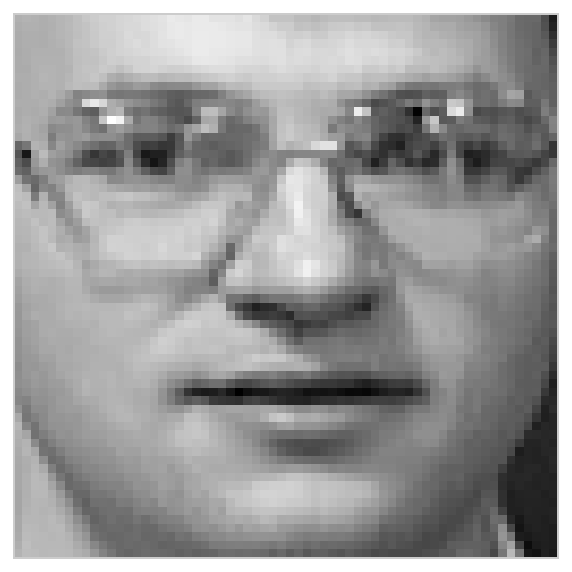

In [209]:
face = process_image(faces[50])
plot_image_matrix(face)

Next I do SVD on the face image and look at the singular value matrix to get a feel for how many components are actually important (account for reasonable variance).

In [30]:
# do SVD on face

# transform S into a diag matrix

# plot_image_matrix S


Looks like the first 5 or 6 have a decent proportion of all the variance across the pixel columns. We can look at what the face reconstruction looks like just using those first 5 singular values. 

In [29]:
pc = 5
# reconstruct the image faces[50] by using only the first principal components

# plot the reconstructed image

# plot the original image

To see how reconstruction is affected by different PCs, try adjusting `pc`. What is the smallest value of `pc` such that the image has minimal loss?

Congratulations, you just wrote an image compressor!